# Analytic disk

We create a Magrittetorch model from an analytic description of a Keplerian disk (see e.g. [Homan et al. 2018](https://doi.org/10.1051/0004-6361/201732246); [Booth et al. 2019](https://doi.org/10.1051/0004-6361/201834388)).

## Setup

Import the required functionalty.

In [1]:
import magrittetorch.model.model as magritte
import magrittetorch.tools.mesher as mesher 
import magrittetorch.tools.setup as setup
import numpy             as np                      # Data structures
from astropy import units, constants    # Unit conversions
from astropy.units import Quantity # For function arguments
import os
import torch
import warnings                                     # Hide warnings
warnings.filterwarnings('ignore')                   # especially for yt
import yt                                           # 3D plotting
import os

from tqdm                import tqdm                # Progress bars
from astropy             import units, constants    # Unit conversions
from scipy.spatial       import Delaunay, cKDTree   # Finding neighbors
from yt.funcs            import mylog               # To avoid yt output 
mylog.setLevel(40)                                  # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magrittetorch-examples/Analytic_disk/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
model_file = os.path.join(wdir, 'model_analytic_disk.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                  )   # Line data file

We use a data file that can be downloaded with the following links.

In [5]:
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $lamda_link --output-document $lamda_file

## Model parameters

The functions below describe the disk structure, based on the Magritte application presented in [De Ceuster et al. (2019)](https://doi.org/10.1093/mnras/stz3557).

In [7]:
G      =           constants.G
kb     =           constants.k_B
m_H2   = 2.01588 * constants.u

XCO    =  6.0e-4   # [.]
vturb  =  1.5e+3 * units.m/units.s  # [m/s]

M_star =     2.0 * constants.M_sun
r_star =     2.0 * constants.au
T_star =    2500 * units.K  # [K]

rho_in = 5.0e-12 * units.kg/units.m**3  # [kg/m^3]
r_out  =   600.0 * constants.au
r_in   =    10.0 * constants.au
T_in   =    1500 * units.K  # [K]

p      =  -2.125   # [.]
h      =   1.125   # [.]
q      =  -0.5     # [.]


def cylindrical(x: Quantity[units.m], y: Quantity[units.m], z: Quantity[units.m])-> tuple[Quantity[units.m], Quantity[units.dimensionless_unscaled], Quantity[units.m]]:
    """
    Convert cartesian to cylindrical coordinates.
    """
    rxy = np.sqrt   (x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rxy, phi, z)


def H(rxy: Quantity[units.m]) -> Quantity[units.m]:
    """
    Vertical Gaussian scale height.
    """
    # Compute prefactor
    prefactor = r_in * np.sqrt(kb * T_in / m_H2 * r_in / (G * M_star))
    # Return power law result
    return prefactor * np.power(rxy/r_in, h)


def density(rr: [Quantity[units.m], Quantity[units.m], Quantity[units.m]]) -> Quantity[units.kg/units.m**3]:
    """
    Keplerian disk density in cylindrical coordinates.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[:,0],rr[:,1],rr[:,2])
    # Compute density
    rho = rho_in * np.power(rxy/r_in, p) * np.exp(-0.5 * (z/H(rxy))**2)
    # Set radii below r_in to zero (in a way that also work for np arrays)
    if hasattr(rxy, "__len__"):
        rho[rxy<r_in] = 0.0
    else:
        if (rxy<r_in):
            rho = 0.0
    # Return result
    return rho


def abn_nH2(rr: [Quantity[units.m], Quantity[units.m], Quantity[units.m]]) -> Quantity[units.m**-3]:
    """
    H2 number density function.
    """
    return density(rr) / (2.01588 * constants.u)


def abn_nCO(rr: [Quantity[units.m], Quantity[units.m], Quantity[units.m]]) -> Quantity[units.m**-3]:
    """
    CO number density function.
    """
    return XCO * abn_nH2(rr)


def temperature(rr: [Quantity[units.m], Quantity[units.m], Quantity[units.m]]) -> Quantity[units.K]:
    """
    Temperature structure.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[:,0],rr[:,1],rr[:,2])
    # Get spherical radial coordinate
    r = np.sqrt(rxy**2 + z**2)
    # Compute temperature
    return T_star * np.power(r/r_star, q)

    
def velocity_f(rr: [Quantity[units.m], Quantity[units.m], Quantity[units.m]]) -> Quantity[units.m/units.s]:
    """
    Velocity structure.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[:,0],rr[:,1],rr[:,2])
    # Get spherical radial coordinate
    r = np.sqrt(rxy**2 + z**2)
    # Compute angle
    d = phi.si.value + 0.5 * np.pi
    # Compute velocity (in carthesian)
    return np.sqrt(G * M_star/r)[:, np.newaxis] * np.stack([np.cos(d), np.sin(d), np.zeros_like(d)], axis=1)

## Create background mesh

Define the desired background mesh, a ($75 \times 75 \times 75$) cube.

In [8]:
resolution = 75

xs = np.linspace(-r_out, +r_out, resolution, endpoint=True)
ys = np.linspace(-r_out, +r_out, resolution, endpoint=True)
zs = np.linspace(-r_out, +r_out, resolution, endpoint=True)

(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

# Extract positions of points in background mesh
position = np.stack((Xs.ravel(), Ys.ravel(), Zs.ravel()), axis=1)

# Evaluate the density on the cube
rhos      = density(np.stack([Xs, Ys, Zs], axis=1))
rhos_min  = np.min(rhos[rhos!=0.0])
rhos     += rhos_min

Now we remesh this model using the new remesher

In [9]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, rhos.si.value.ravel(), max_depth=10, threshold= 2e-1, hullorder=4)

new interior points:  198688
number boundary points:  1538


We add a spherical inner boundary at 0.01*r_out

In [10]:
healpy_order = 5 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T * units.m #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_inner_boundary(positions_reduced, nb_boundary, 0.01*r_out, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))
print("number of boundary points: ", nb_boundary)
#Magritte-torch does not yet support having an inner boundary, so we just treat them as normal points
nb_boundary = 0

number of points in reduced grid:  200525
number of boundary points:  1838


We add a spherical outer boundary at r_out

In [11]:
healpy_order = 15 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T * units.m #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_outer_boundary(positions_reduced, nb_boundary, r_out, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))

number of points in reduced grid:  114051


In [12]:
npoints = len(positions_reduced)

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(positions_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

Convert model functions to arrays based the model mesh.

In [13]:
position = positions_reduced
velocity = velocity_f (positions_reduced)
nH2      = abn_nH2    (positions_reduced)
nCO      = abn_nCO    (positions_reduced)
tmp      = temperature(positions_reduced)
trb      = np.ones(len(tmp))*vturb

## Create model

Now all data is read, we can use it to construct a Magrittetorch model.

<div class="alert alert-warning">

Warning

Including all radiative transitions can be computationally expensive (both in time and memory cost) for self-consistent NLTE radiative transfer. For LTE radiative transfer, this is not the case, altough if one wants to image a specific line, that line must be in the list of considered transitions. For these examples, we include the first 10 radiative transitions of CO (J=1-0 to J=10-9). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [14]:
from magrittetorch.model.geometry.geometry import GeometryType
from magrittetorch.model.geometry.boundary import BoundaryType

model = magritte.Model(model_file) # Create model object
model.geometry.geometryType.set(GeometryType.General3D) # This is a 3D model
model.geometry.boundary.boundaryType.set(BoundaryType.Sphere3D) # With a spherical boundary

# In order to make unit conversions trivial, we use astropy quantities as input
model.geometry.points.position.set_astropy(position) # Set point positions
model.geometry.points.velocity.set_astropy(velocity) # Set point velocities
model.chemistry.species.abundance.set_astropy(np.stack([nCO, nH2, zeros/units.m**3], axis=1))# Set species number densities
model.chemistry.species.symbol.set(np.array(['CO', 'H2', 'e-'], dtype='S')) #Set species symbols; should correspond to the LAMDA file format
#Note: the dtype='S' is necessary to correctly save and read the species symbols to/from the hdf5 file

model.thermodynamics.temperature.gas.set_astropy(tmp) # Set gas temperature
model.thermodynamics.turbulence.vturb.set_astropy(trb) # Set turbulence velocity

model = setup.set_Delaunay_neighbor_lists (model) # Automatically computes and sets neighbors for each point, using a Delaunay triangulation
# For unitless quantities, we can also directly set the torch tensors
boundary_indices = torch.arange(nb_boundary, dtype = torch.int64)
model.geometry.boundary.boundary2point.set(boundary_indices) # Set which points are boundary points
# Conveniently, the remeshing function puts the boundary points in front of the positions array
model = setup.set_boundary_condition_CMB  (model) # Set CMB as boundary condition
model = setup.set_uniform_rays            (model, 12) # Number of rays for NLTE raytracing; has be of the form 12*2**n

#As this example does not do NLTE, we might as well only consider the first 10 transitions of CO
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [i for i in range(10)]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model, 7) # Set number of quadrature points for NLTE radiative transfer

# And write the model to disk
model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing model to:  /lhome/thomasc/Magrittetorch-examples/Analytic_disk/model_analytic_disk.hdf5


## Plot model

Load the data in a `yt` unstructured mesh.

In [15]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis and x-axis.


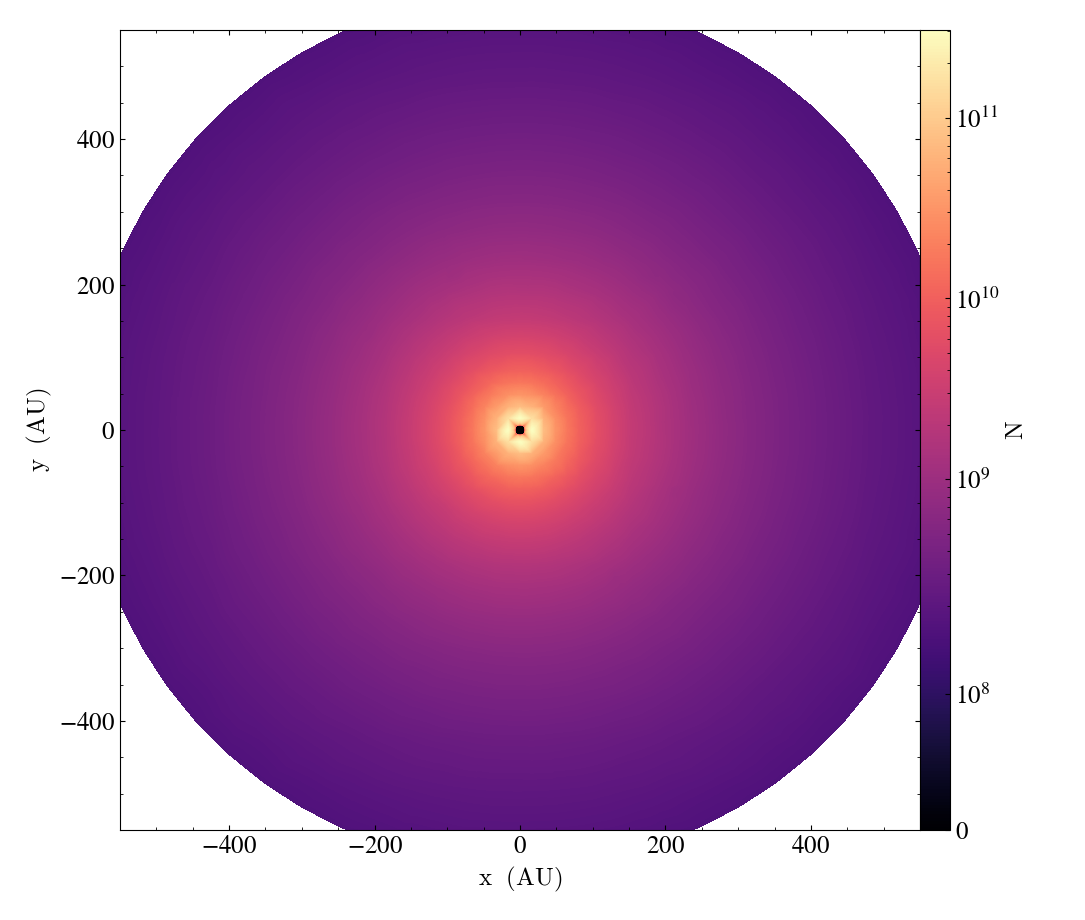

In [16]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)


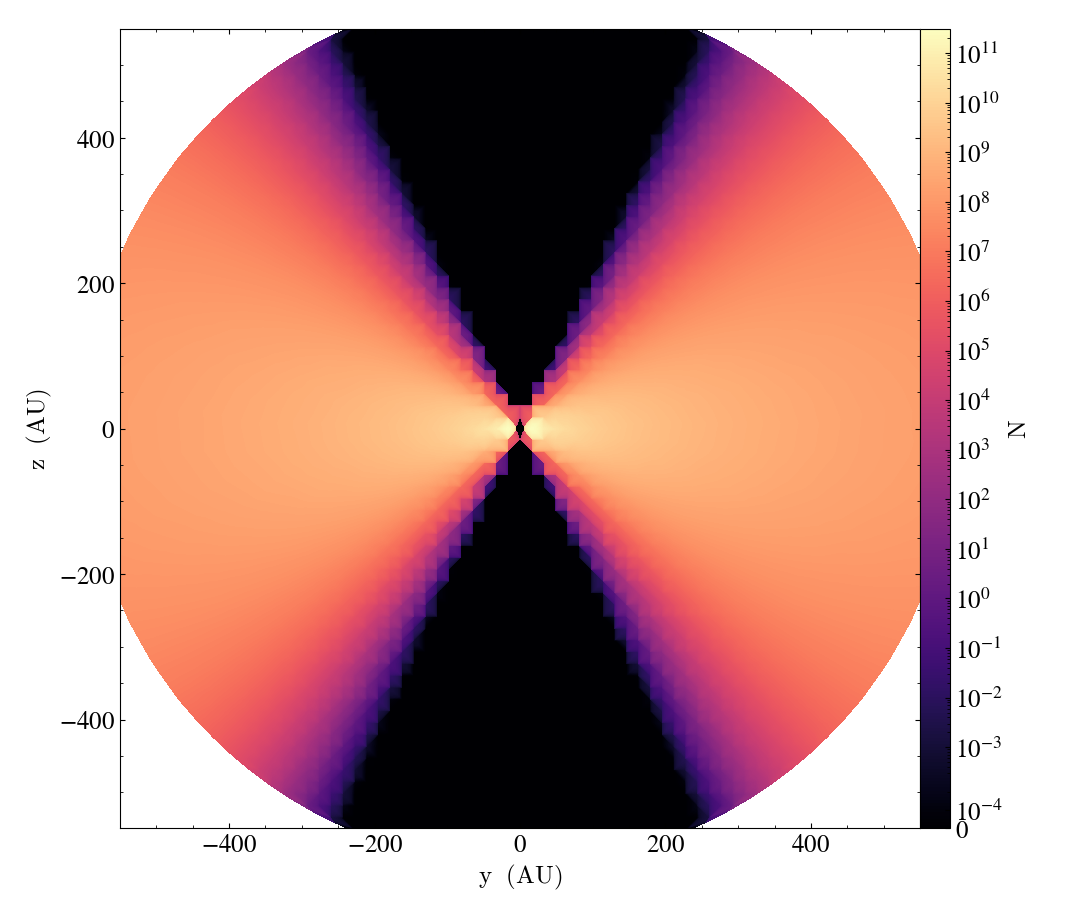

In [17]:
sl = yt.SlicePlot (ds, 'x', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show meshes on the plots.


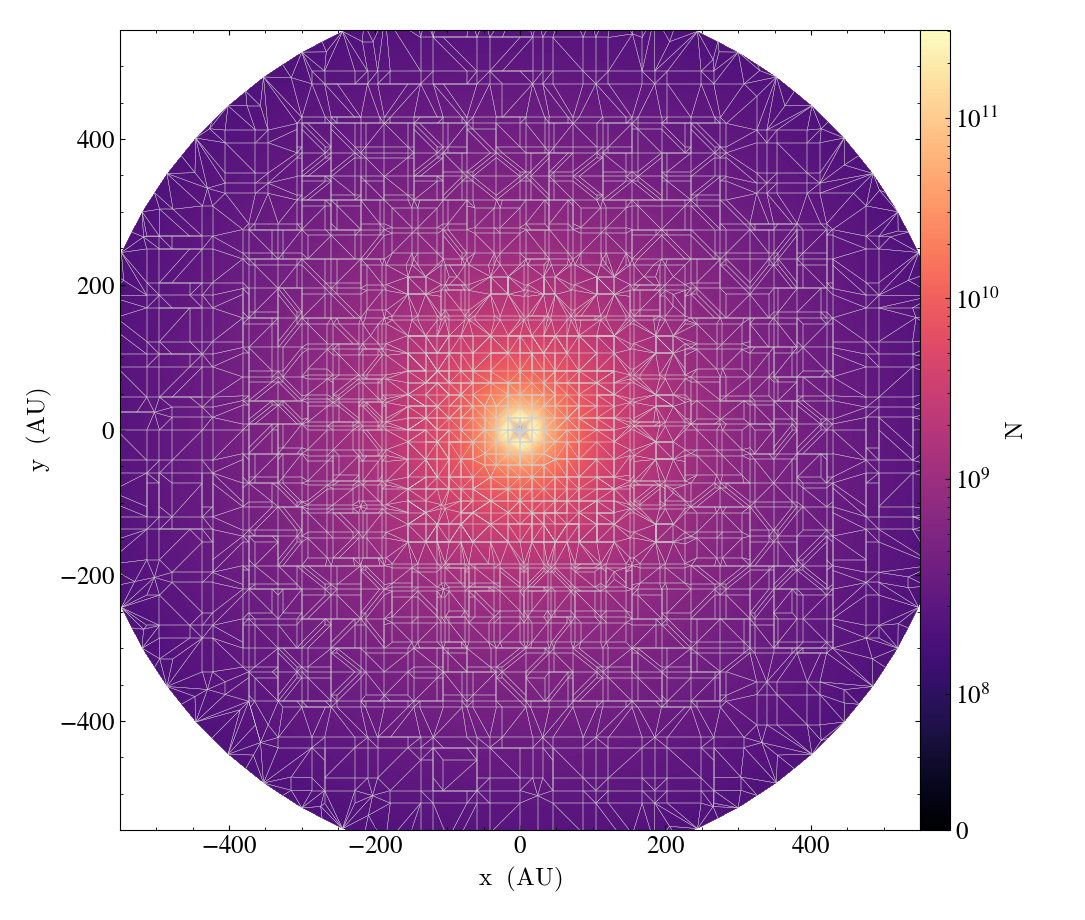

In [18]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


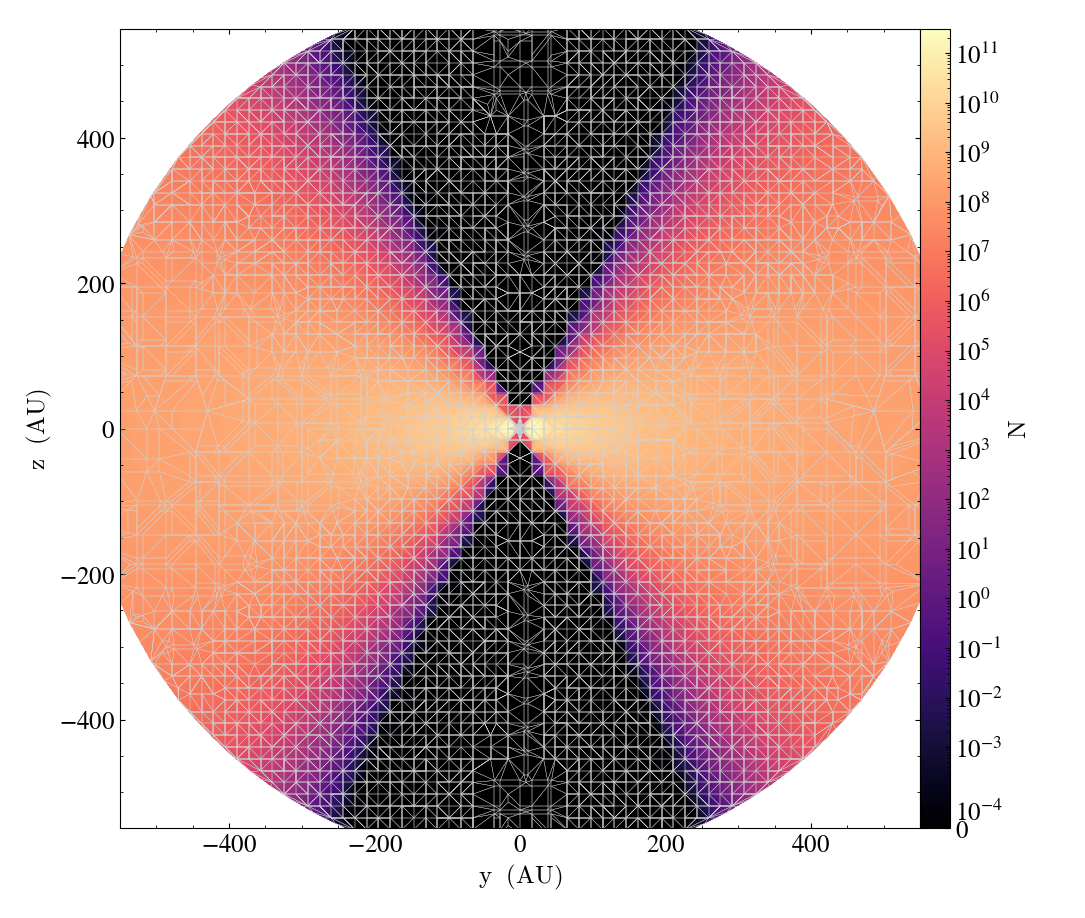

In [19]:
sl = yt.SlicePlot      (ds, 'x', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})